# Librerías

In [ ]:
# Importamos librerías a utilizar
import pandas as pd
import numpy as np
import re

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import seaborn as sns
import matplotlib.pyplot as plt
import math
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

from imblearn.combine import SMOTEENN, SMOTETomek

from pandas import DataFrame

# Carga y visualización del dataset

El dataset se llama weatherAUS.csv y contiene información climática de Australia de los
últimos diez años, incluyendo si para el día siguiente llovió o no en la columna
‘RainTomorrow’. El objetivo del trabajo práctico es armar un ejecutable de Docker para
predecir, a las 23:59:59hs de cada día, si el día siguiente va a llover o no. Tiene alrededor de 145.460 y 23 columnas.

In [ ]:
file_path= 'weatherAUS.csv'

df = pd.read_csv(file_path)

In [ ]:
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [ ]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

# 1. Clusters por región

In [ ]:
ciudades = df["Location"].unique()
print(ciudades)

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']


Se precisa transformar algunos nombres de ciudades para poder generar los clusters correspondientes a las distintas regiones.

In [ ]:
def formatear_ciudad(ciudad_sin_formato: str):
    """Función para formatear la ciudad"""
    ciudad = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', ciudad_sin_formato) + ", Australia"
    return ciudad

In [ ]:
geolocator = Nominatim(user_agent="weatherAUS") # Instanciamos el geolocalizador
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1, max_retries=3, error_wait_seconds=2.0)
coord = []
for c in ciudades:
    c_form = formatear_ciudad(c)
    try:
        localizacion = geocode(c_form, timeout=10)
        if localizacion:
            coord.append((c, localizacion.latitude, localizacion.longitude))
        else:
            print(f"No se encontró {c}")
    except Exception as e:
        print(f"Error con: {c} - {e}")

df_coord = pd.DataFrame(coord, columns=["Location","Latitude","Longitude"])

## Método del codo

Para agrupar las ciudades en regiones se utilizará el algoritmo K-means, donde se usará el método del codo para calcular un valor adecuado de k.

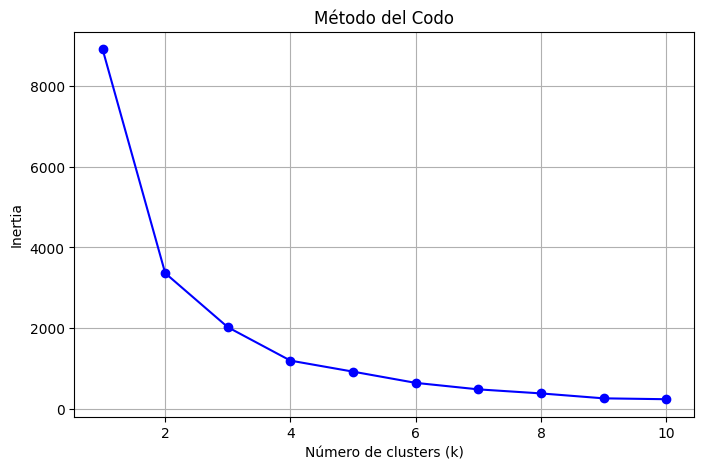

In [ ]:
matriz_de_coordenadas = df_coord[['Latitude',  'Longitude']].values

inertias = []
K = range(1,11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(matriz_de_coordenadas)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inertia')
plt.title('Método del Codo')
plt.grid(True)
plt.show()

Del gráfico del método del codo se puede observar cómo a partir de 4 segmentos, la mejora que se produce en la
distancia interna de los segmentos ya es insignificante. Este hecho debería ser
indicativo de que 4 segmentos es un valor adecuado para k. Sin embargo, dado que este método puede ser ambiguo o poco fiable, se decidió buscar una validación adicional probando distintos valores para k.

## Implementación de K-means

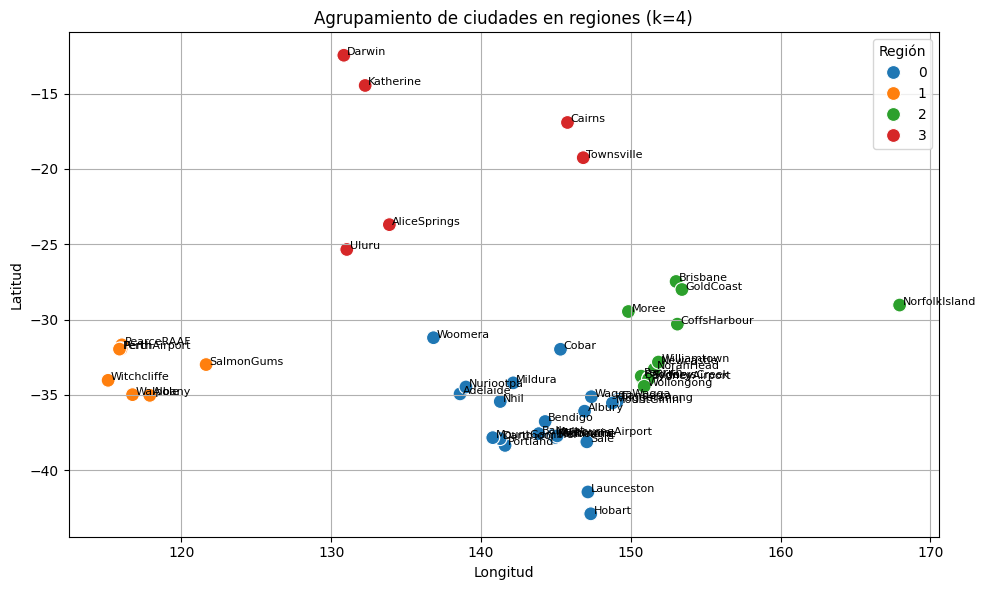

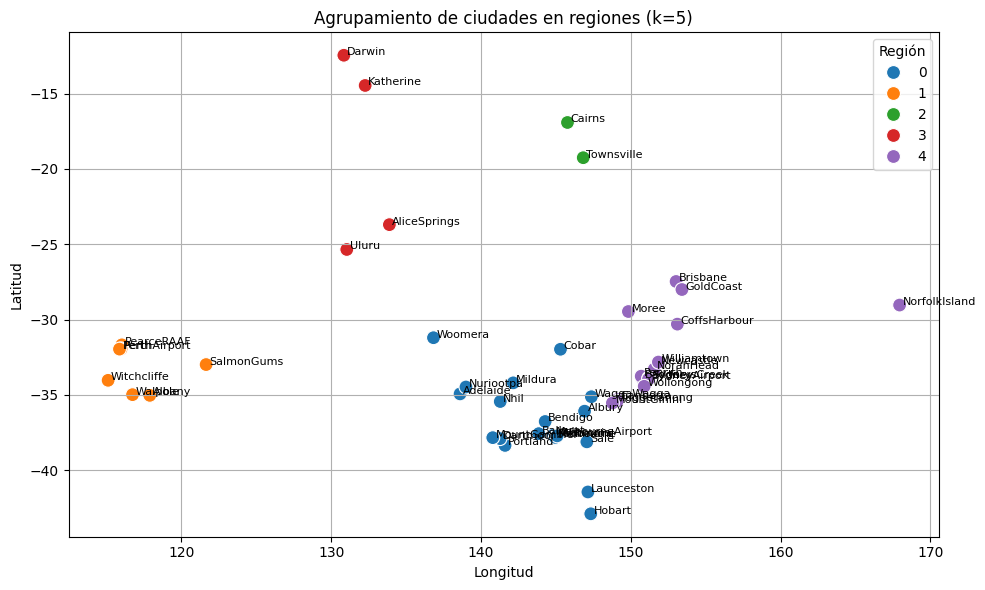

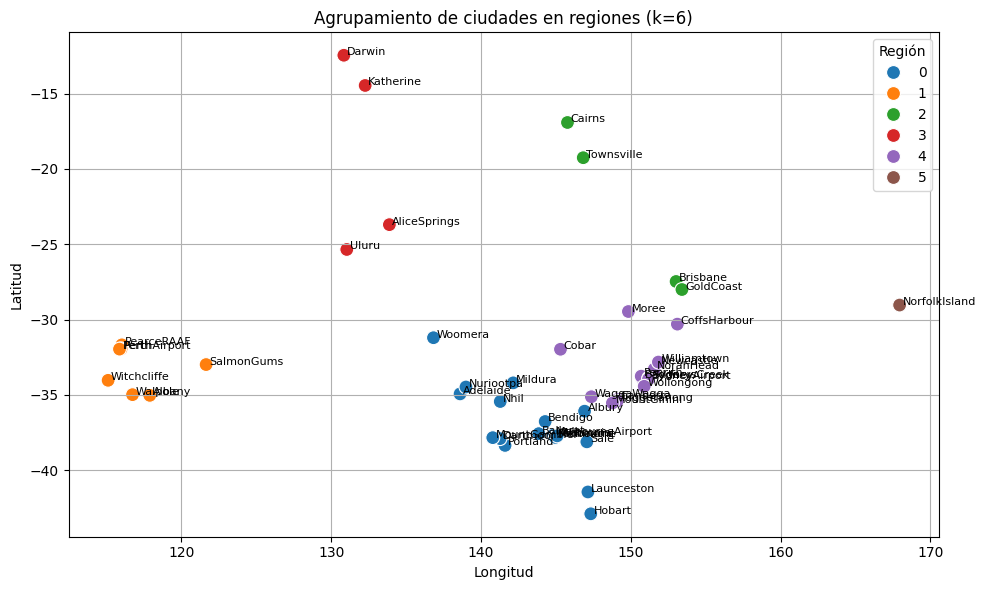

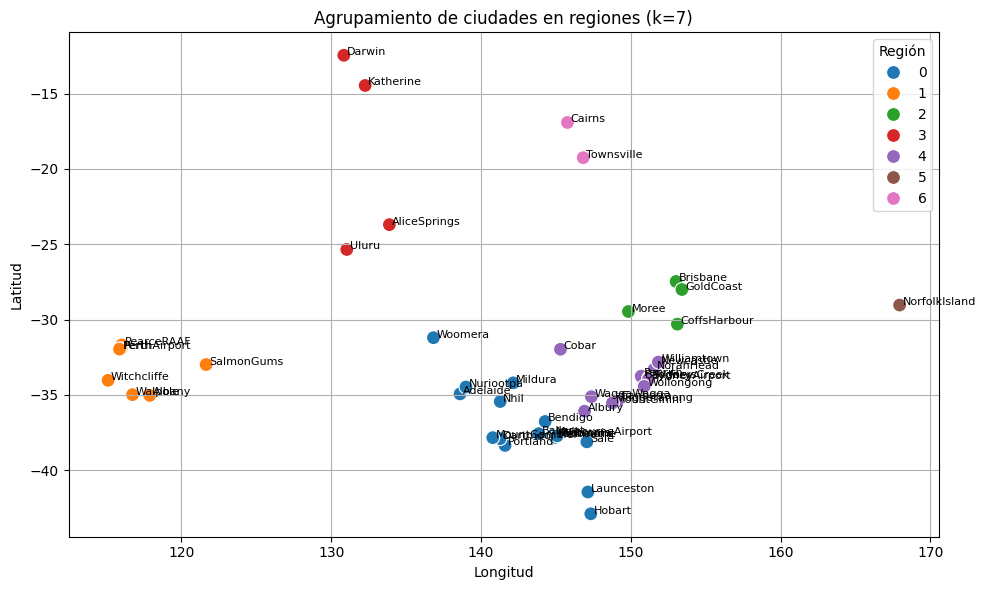

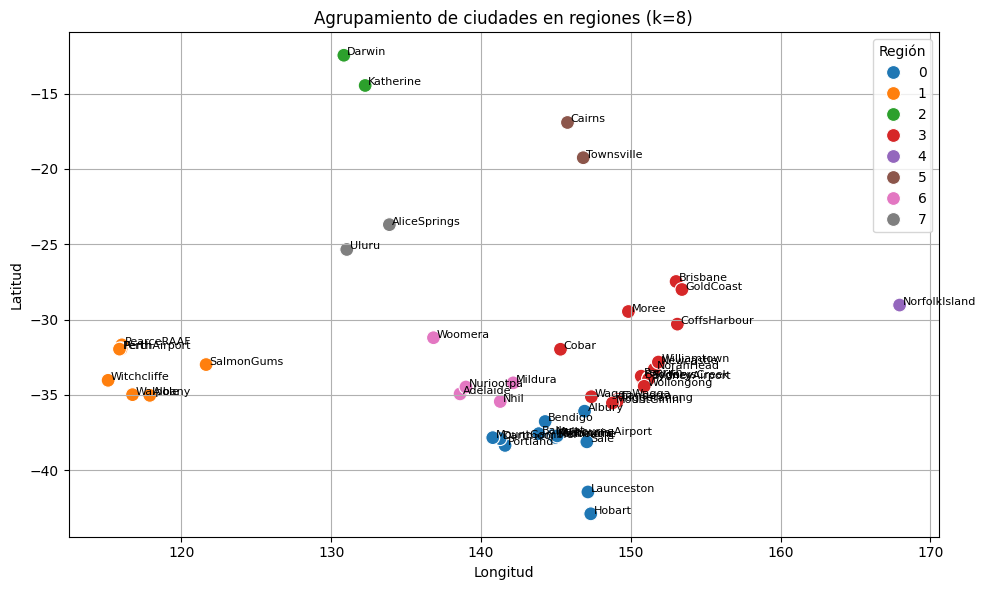

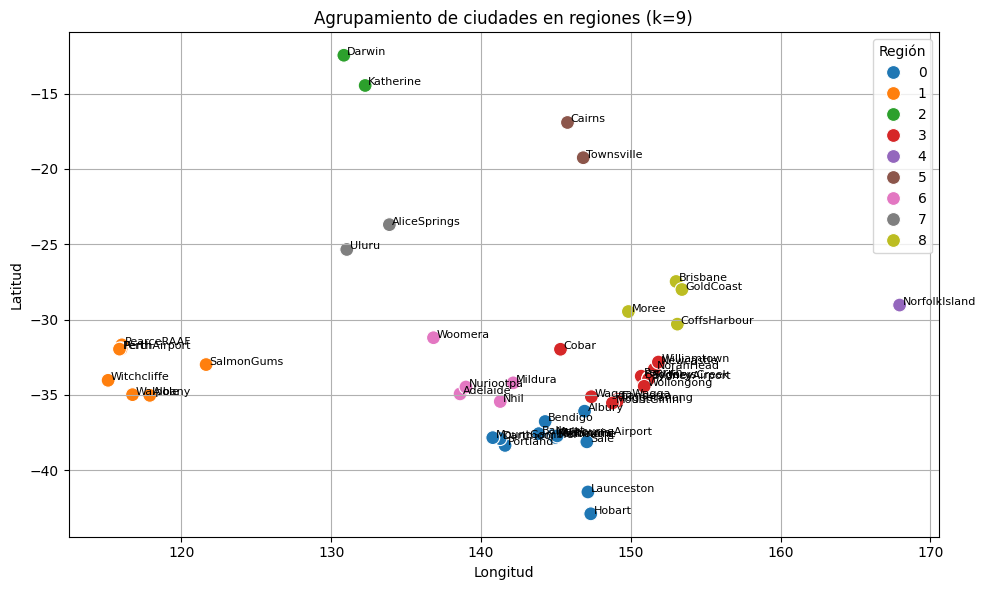

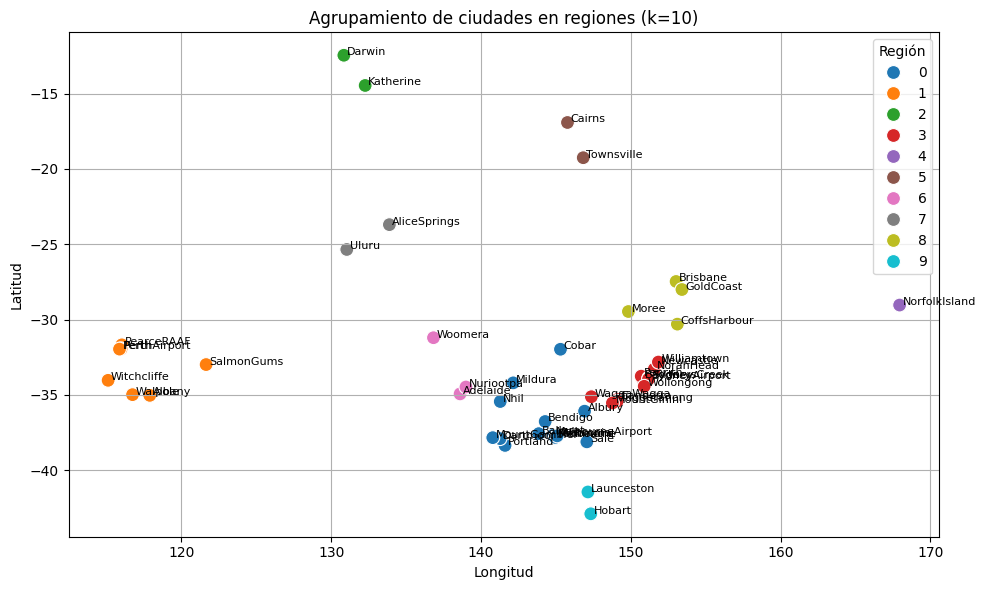

In [ ]:
k_prob = [4, 5, 6, 7, 8, 9, 10]

df_coords_by_k = {}

for k in k_prob:
    df_coord_k = df_coord.copy()

    kmeans = KMeans(n_clusters=k, random_state=42)
    df_coord_k['Region'] = kmeans.fit_predict(df_coord_k[['Latitude', 'Longitude']].values)

    df_coords_by_k[k] = df_coord_k

    # plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df_coord_k,
        x='Longitude', y='Latitude',
        hue='Region',
        palette='tab10',
        s=100
    )

    for _, row in df_coord_k.iterrows():
        plt.text(row['Longitude'] + 0.2, row['Latitude'], row['Location'], fontsize=8)

    plt.title(f'Agrupamiento de ciudades en regiones (k={k})')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.legend(title='Región')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Se procedió a realizar una inspección visual de las agrupaciones de ciudades en un gráfico de latitud y longitud, probando diferentes valores de k. Se buscó el valor de k que mejor alineara los clusters con las regiones geográficas y climáticas conocidas de Australia (https://www.researchgate.net/figure/Major-seasonal-rainfall-zones-of-Australia-source-Bureau-of-Meteorology-National_fig3_228535345). Se decidió elegir k=8.

# 2. Análisis descriptivo de datos

## Datos faltantes

In [ ]:
def check_nan_percentage(df):
    nan_cant = df.isna().sum()
    nan_porcentaje = (nan_cant / len(df)) * 100

    nan_info = pd.DataFrame({
        'Cantidad': nan_cant,
        'Porcentaje': nan_porcentaje
    })

    nan_info['Porcentaje'] = nan_info['Porcentaje'].apply(lambda x: f"{x:.2f}%")

    print(nan_info)

check_nan_percentage(df)

               Cantidad Porcentaje
Date                  0      0.00%
Location              0      0.00%
MinTemp            1485      1.02%
MaxTemp            1261      0.87%
Rainfall           3261      2.24%
Evaporation       62790     43.17%
Sunshine          69835     48.01%
WindGustDir       10326      7.10%
WindGustSpeed     10263      7.06%
WindDir9am        10566      7.26%
WindDir3pm         4228      2.91%
WindSpeed9am       1767      1.21%
WindSpeed3pm       3062      2.11%
Humidity9am        2654      1.82%
Humidity3pm        4507      3.10%
Pressure9am       15065     10.36%
Pressure3pm       15028     10.33%
Cloud9am          55888     38.42%
Cloud3pm          59358     40.81%
Temp9am            1767      1.21%
Temp3pm            3609      2.48%
RainToday          3261      2.24%
RainTomorrow       3267      2.25%


In [ ]:
df = df.merge(df_coords_by_k[8][['Location', 'Region']], on="Location", how="left")
df = df.drop(columns=['Location'])

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

def estacion(date):
    mes = date.month
    if mes in [12, 1, 2]:
        return 'Verano'
    elif mes in [3, 4, 5]:
        return 'Otoño'
    elif mes in [6, 7, 8]:
        return 'Invierno'
    else:
        return 'Primavera'

df['Season'] = df['Date'].apply(estacion)
df = df.drop(columns=['Date'])

Se eliminan valores nulos de la variable objetivo en el dataset.

In [ ]:
df = df[df["RainTomorrow"].notna()]

Se eliminan las filas con más de la mitad de datos nulos.

In [ ]:
df = df.dropna(thresh=df.shape[1] - (df.shape[1] // 2 + 1))

In [ ]:
check_nan_percentage(df)

               Cantidad Porcentaje
MinTemp             373      0.26%
MaxTemp             221      0.16%
Rainfall           1281      0.90%
Evaporation       60515     42.67%
Sunshine          67479     47.58%
WindGustDir        9041      6.37%
WindGustSpeed      8981      6.33%
WindDir9am         9666      6.82%
WindDir3pm         3464      2.44%
WindSpeed9am       1051      0.74%
WindSpeed3pm       2325      1.64%
Humidity9am        1481      1.04%
Humidity3pm        3310      2.33%
Pressure9am       13689      9.65%
Pressure3pm       13662      9.63%
Cloud9am          53360     37.62%
Cloud3pm          56754     40.01%
Temp9am             617      0.44%
Temp3pm            2429      1.71%
RainToday          1281      0.90%
RainTomorrow          0      0.00%
Region                0      0.00%
Season                0      0.00%


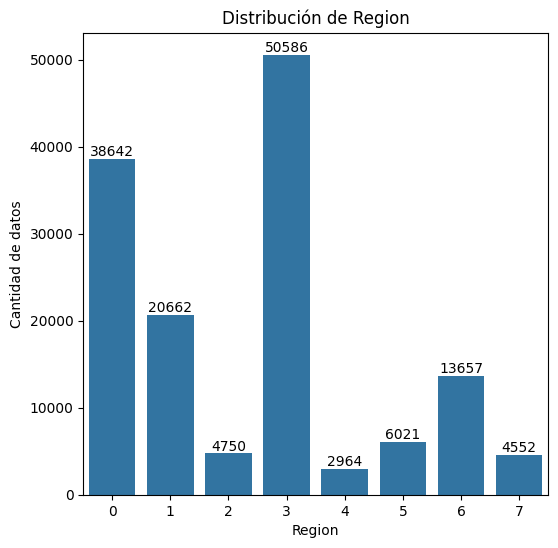

In [ ]:
# Distribución de la variable Region
plt.figure(figsize=(6, 6))
ax = sns.countplot(x=df['Region'])

for container in ax.containers:
    ax.bar_label(container)

plt.title('Distribución de Region')
plt.xlabel('Region')
plt.ylabel('Cantidad de datos')
plt.show()

El gráfico revela una distribución desbalanceada de 'Region'. Las regiones 3 y 0 son las dominantes, concentrando la mayor cantidad de datos. En contraste, las regiones 2, 4 y 7 tienen una representación muy baja. Este desbalance refleja una distribución no uniforme de las observaciones climáticas en Australia, lo cual será considerado en las etapas de entrenamiento para evitar que el modelo tenga un bajo rendimiento o sesgo en la predicción de lluvia en las regiones menos representadas.

## Boxplots de cada variable

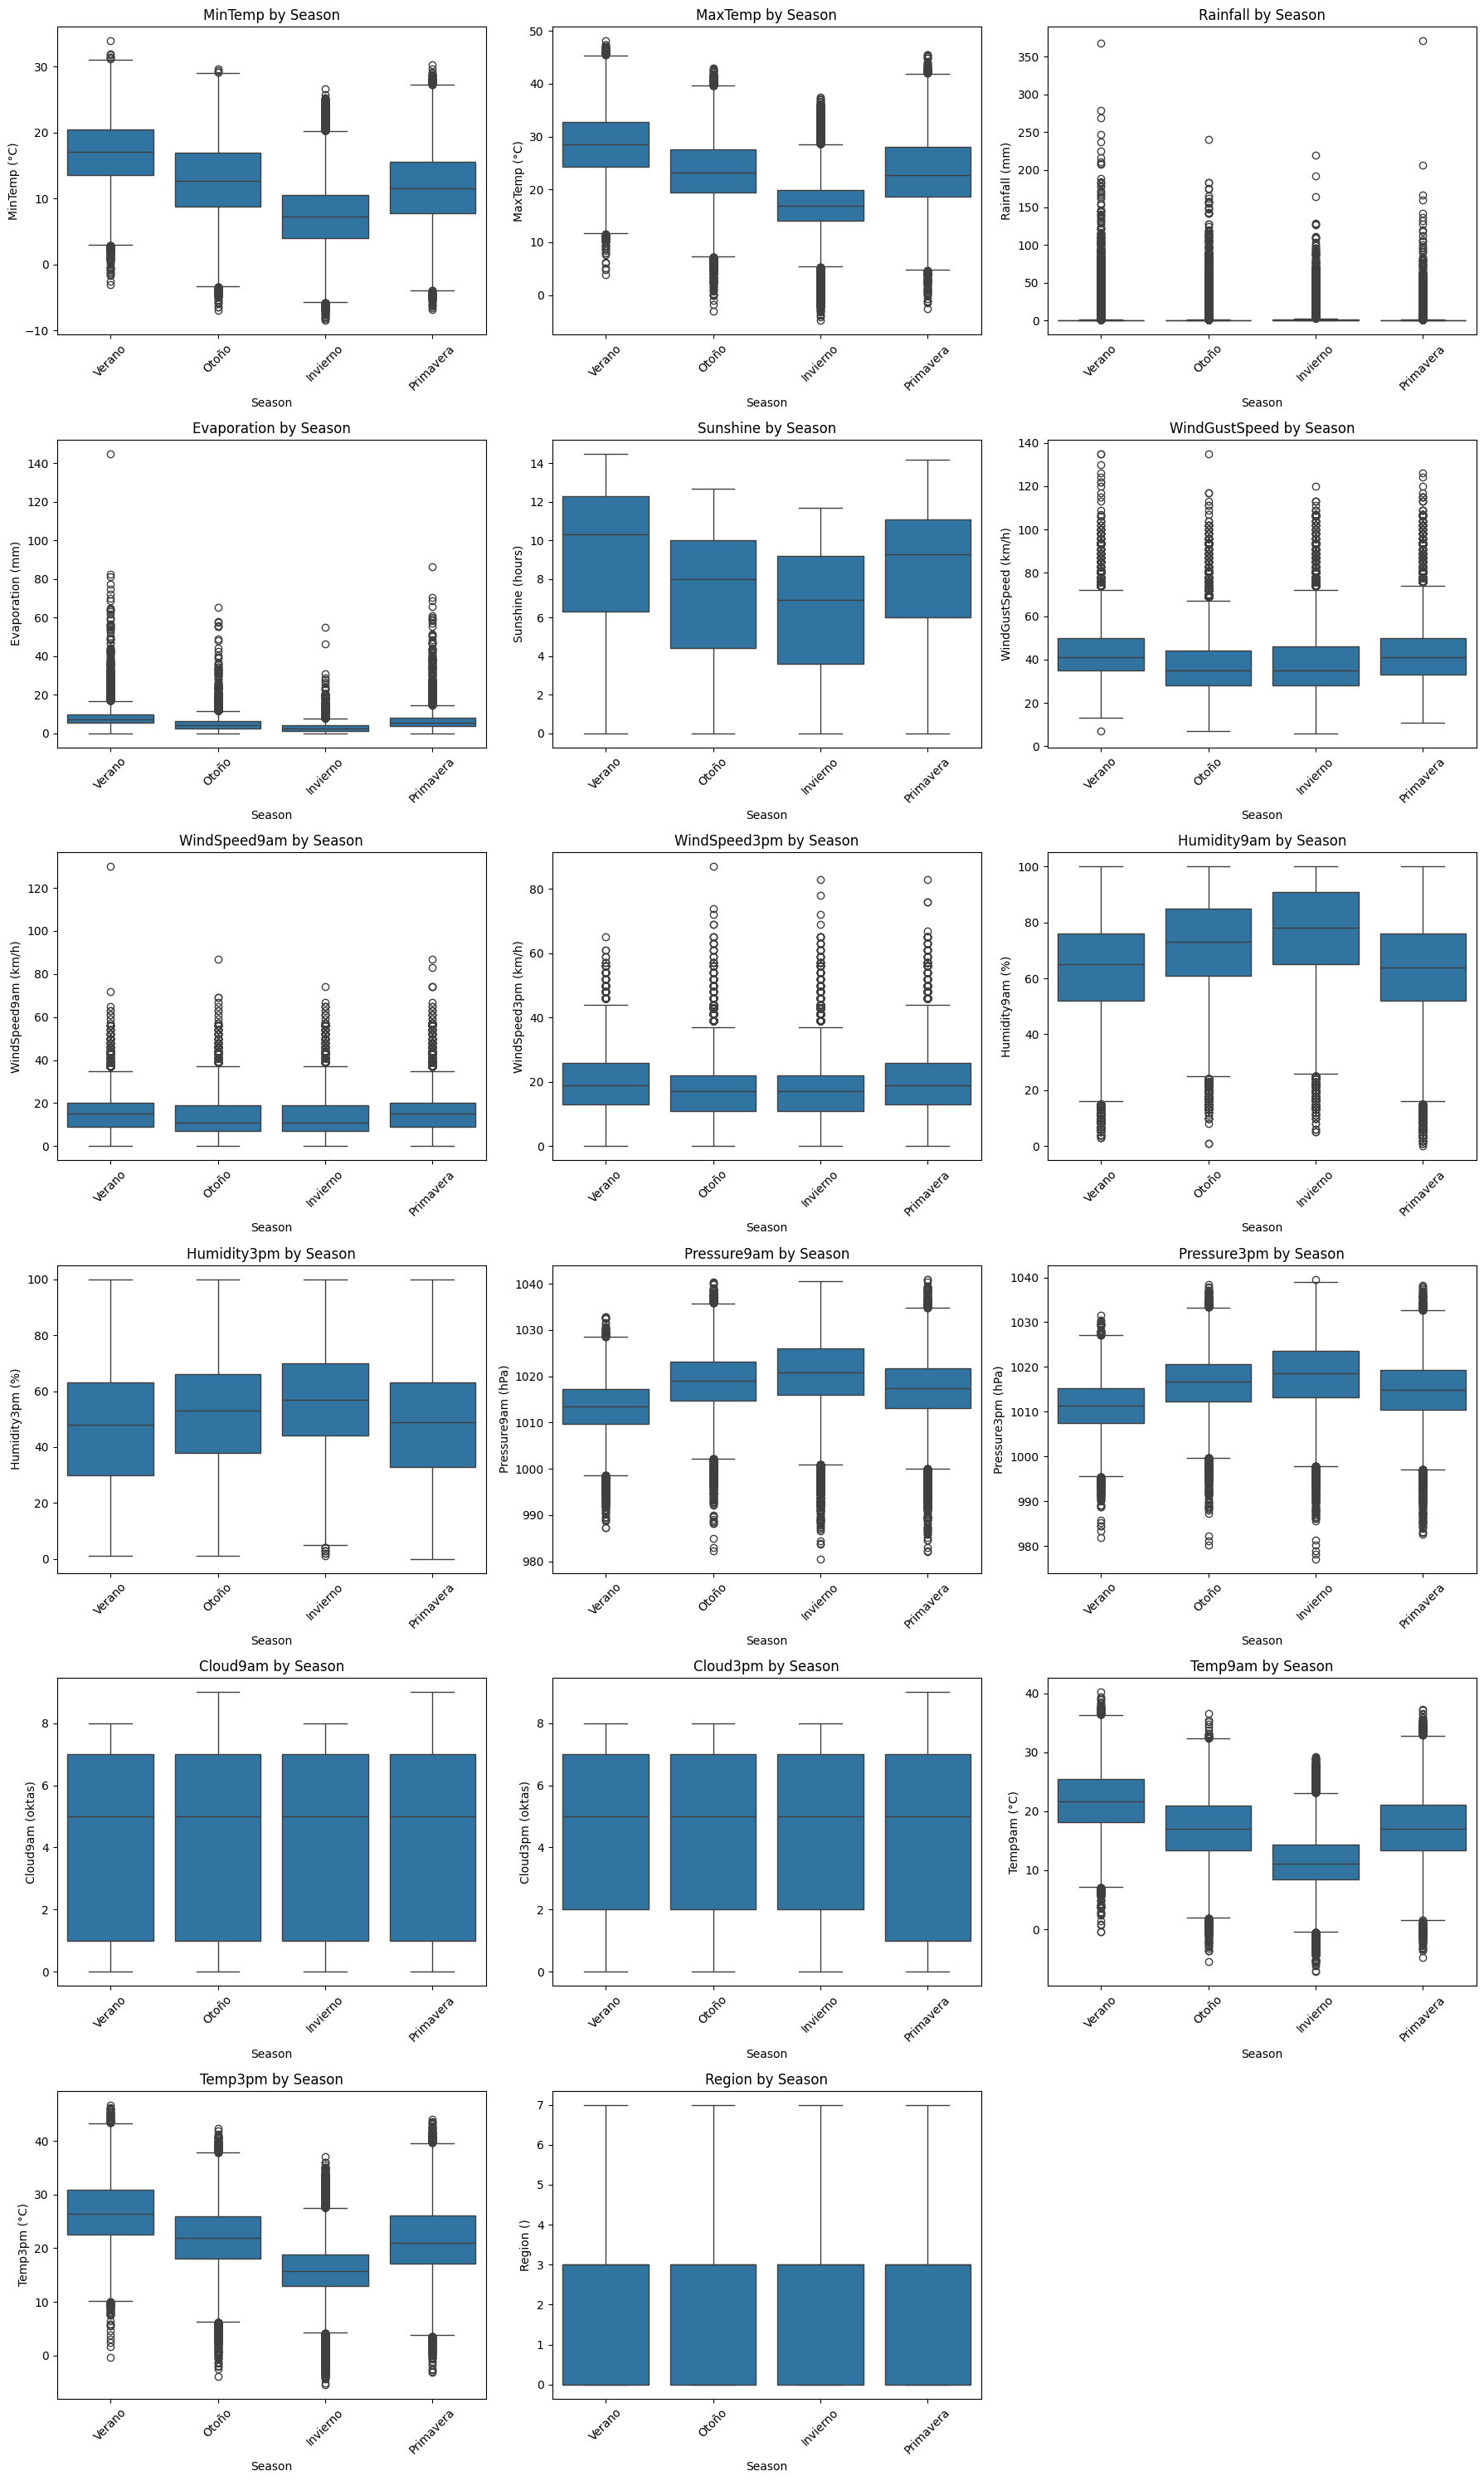

In [ ]:
# Se seleccionan las columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Se agregan las unidades correspondientes
units = {
    'MinTemp': '°C',
    'MaxTemp': '°C',
    'Rainfall': 'mm',
    'Evaporation': 'mm',
    'Sunshine': 'hours',
    'WindGustSpeed': 'km/h',
    'WindSpeed9am': 'km/h',
    'WindSpeed3pm': 'km/h',
    'Humidity9am': '%',
    'Humidity3pm': '%',
    'Pressure9am': 'hPa',
    'Pressure3pm': 'hPa',
    'Cloud9am': 'oktas',
    'Cloud3pm': 'oktas',
    'Temp9am': '°C',
    'Temp3pm': '°C'
}

# Número de subplots y columnas
n_cols = len(numeric_cols)
n_rows = math.ceil(n_cols / 3)

# Subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5 * n_rows))
axes = axes.flatten()

# Boxplot para cada columna numérica
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x='Season', y=col, ax=axes[i])
    axes[i].set_title(f'{col} by Season')
    axes[i].set_xlabel('Season')
    axes[i].set_ylabel(f'{col} ({units.get(col, "")})')
    axes[i].tick_params(axis='x', rotation=45)

# Se ocultan subplots no útiles
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

A partir de la observación de los boxplots para cada variable y luego de investigar sobre su rango de variación y si los outliers mostrados son valores posibles en Australia, se considerarán todos los valores como posibles.

## Matriz de correlación general y por estación


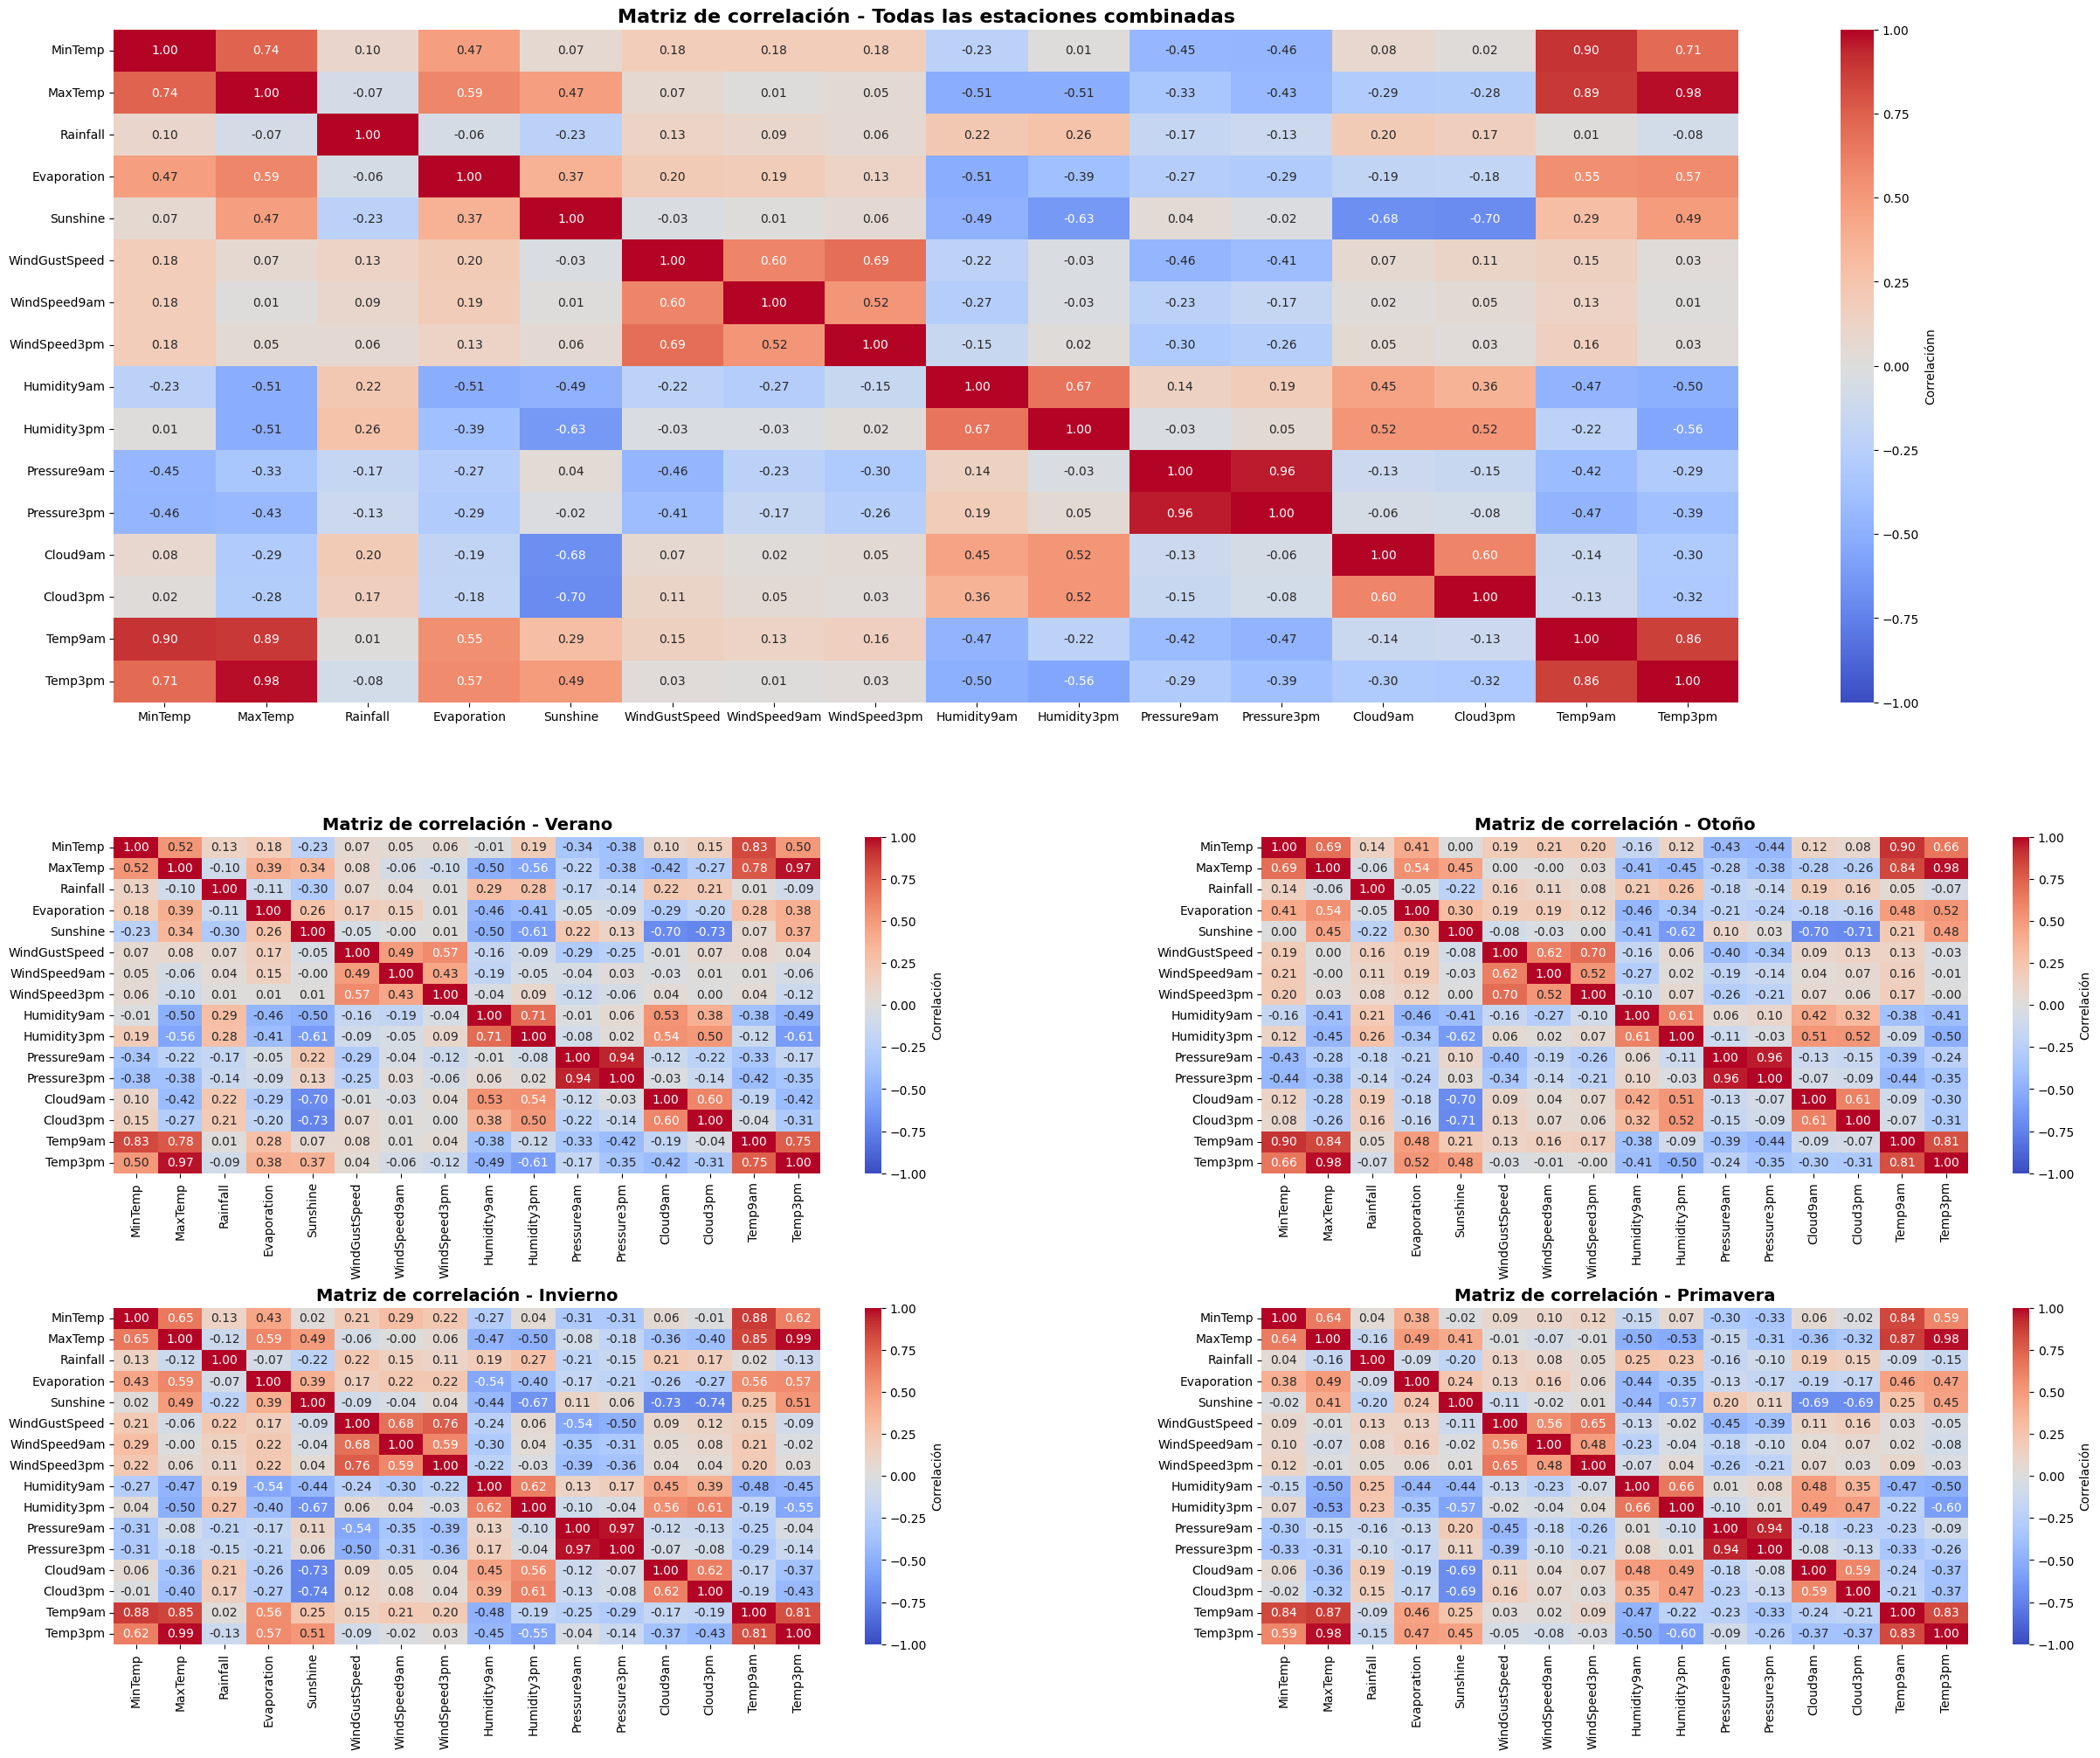

In [ ]:
# Obtener columnas numéricas menos región
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Region' in numeric_cols:
    numeric_cols.remove('Region')

# Obtener estaciones únicas
seasons = df['Season'].unique()

# Crear GridSpec para custom layout
fig = plt.figure(figsize=(30, 24))
gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.3)

# Crear matrices de correlación (sin distinción de estaciones)
ax_overall = fig.add_subplot(gs[0, :])
df_overall = df[numeric_cols]
corr_overall = df_overall.corr().round(2)

sns.heatmap(corr_overall, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', ax=ax_overall, vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlaciónn'})

ax_overall.set_title('Matriz de correlación - Todas las estaciones combinadas', fontsize=16, fontweight='bold')

# Craer subplots para las matrices de correlación por estación
axes_seasons = []
for i in range(2):
    for j in range(2):
        axes_seasons.append(fig.add_subplot(gs[i+1, j]))

# Crear matrices de corrlación por estación
for i, season in enumerate(seasons):
    df_season = df[df['Season'] == season][numeric_cols]

    corr = df_season.corr().round(2)

    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0,
                fmt='.2f', ax=axes_seasons[i], vmin=-1, vmax=1,
                cbar_kws={'label': 'Correlación'})

    axes_seasons[i].set_title(f'Matriz de correlación - {season}', fontsize=14, fontweight='bold')

plt.show()

Sobre la matriz de correlación principal se pueden encontrar correlaciones positivas altas entre variables de temperatura y entre variables climáticas de las 9am y las 3pm. Además se observan algunas correlaciones negativas también altas entre humedad y temperatura, y entre humedad y horas en las que hay sol.

Respecto a las matrices pequeñas divididas por estación, se puede observar que las relaciones entre las variables no son constantes a lo largo del año. Mientras que las temperaturas se mantienen altas en todas las estaciones, las variables de humedad, lluvia o nubosidad cambian de una a otra. Por ejemplo, la correlación entre Rainfall y Cloud9am es mucho más fuerte en invierno que en verano, como pasa también en el caso de Humidity3pm y Rainfall.

## Distribución de la densidad por estación

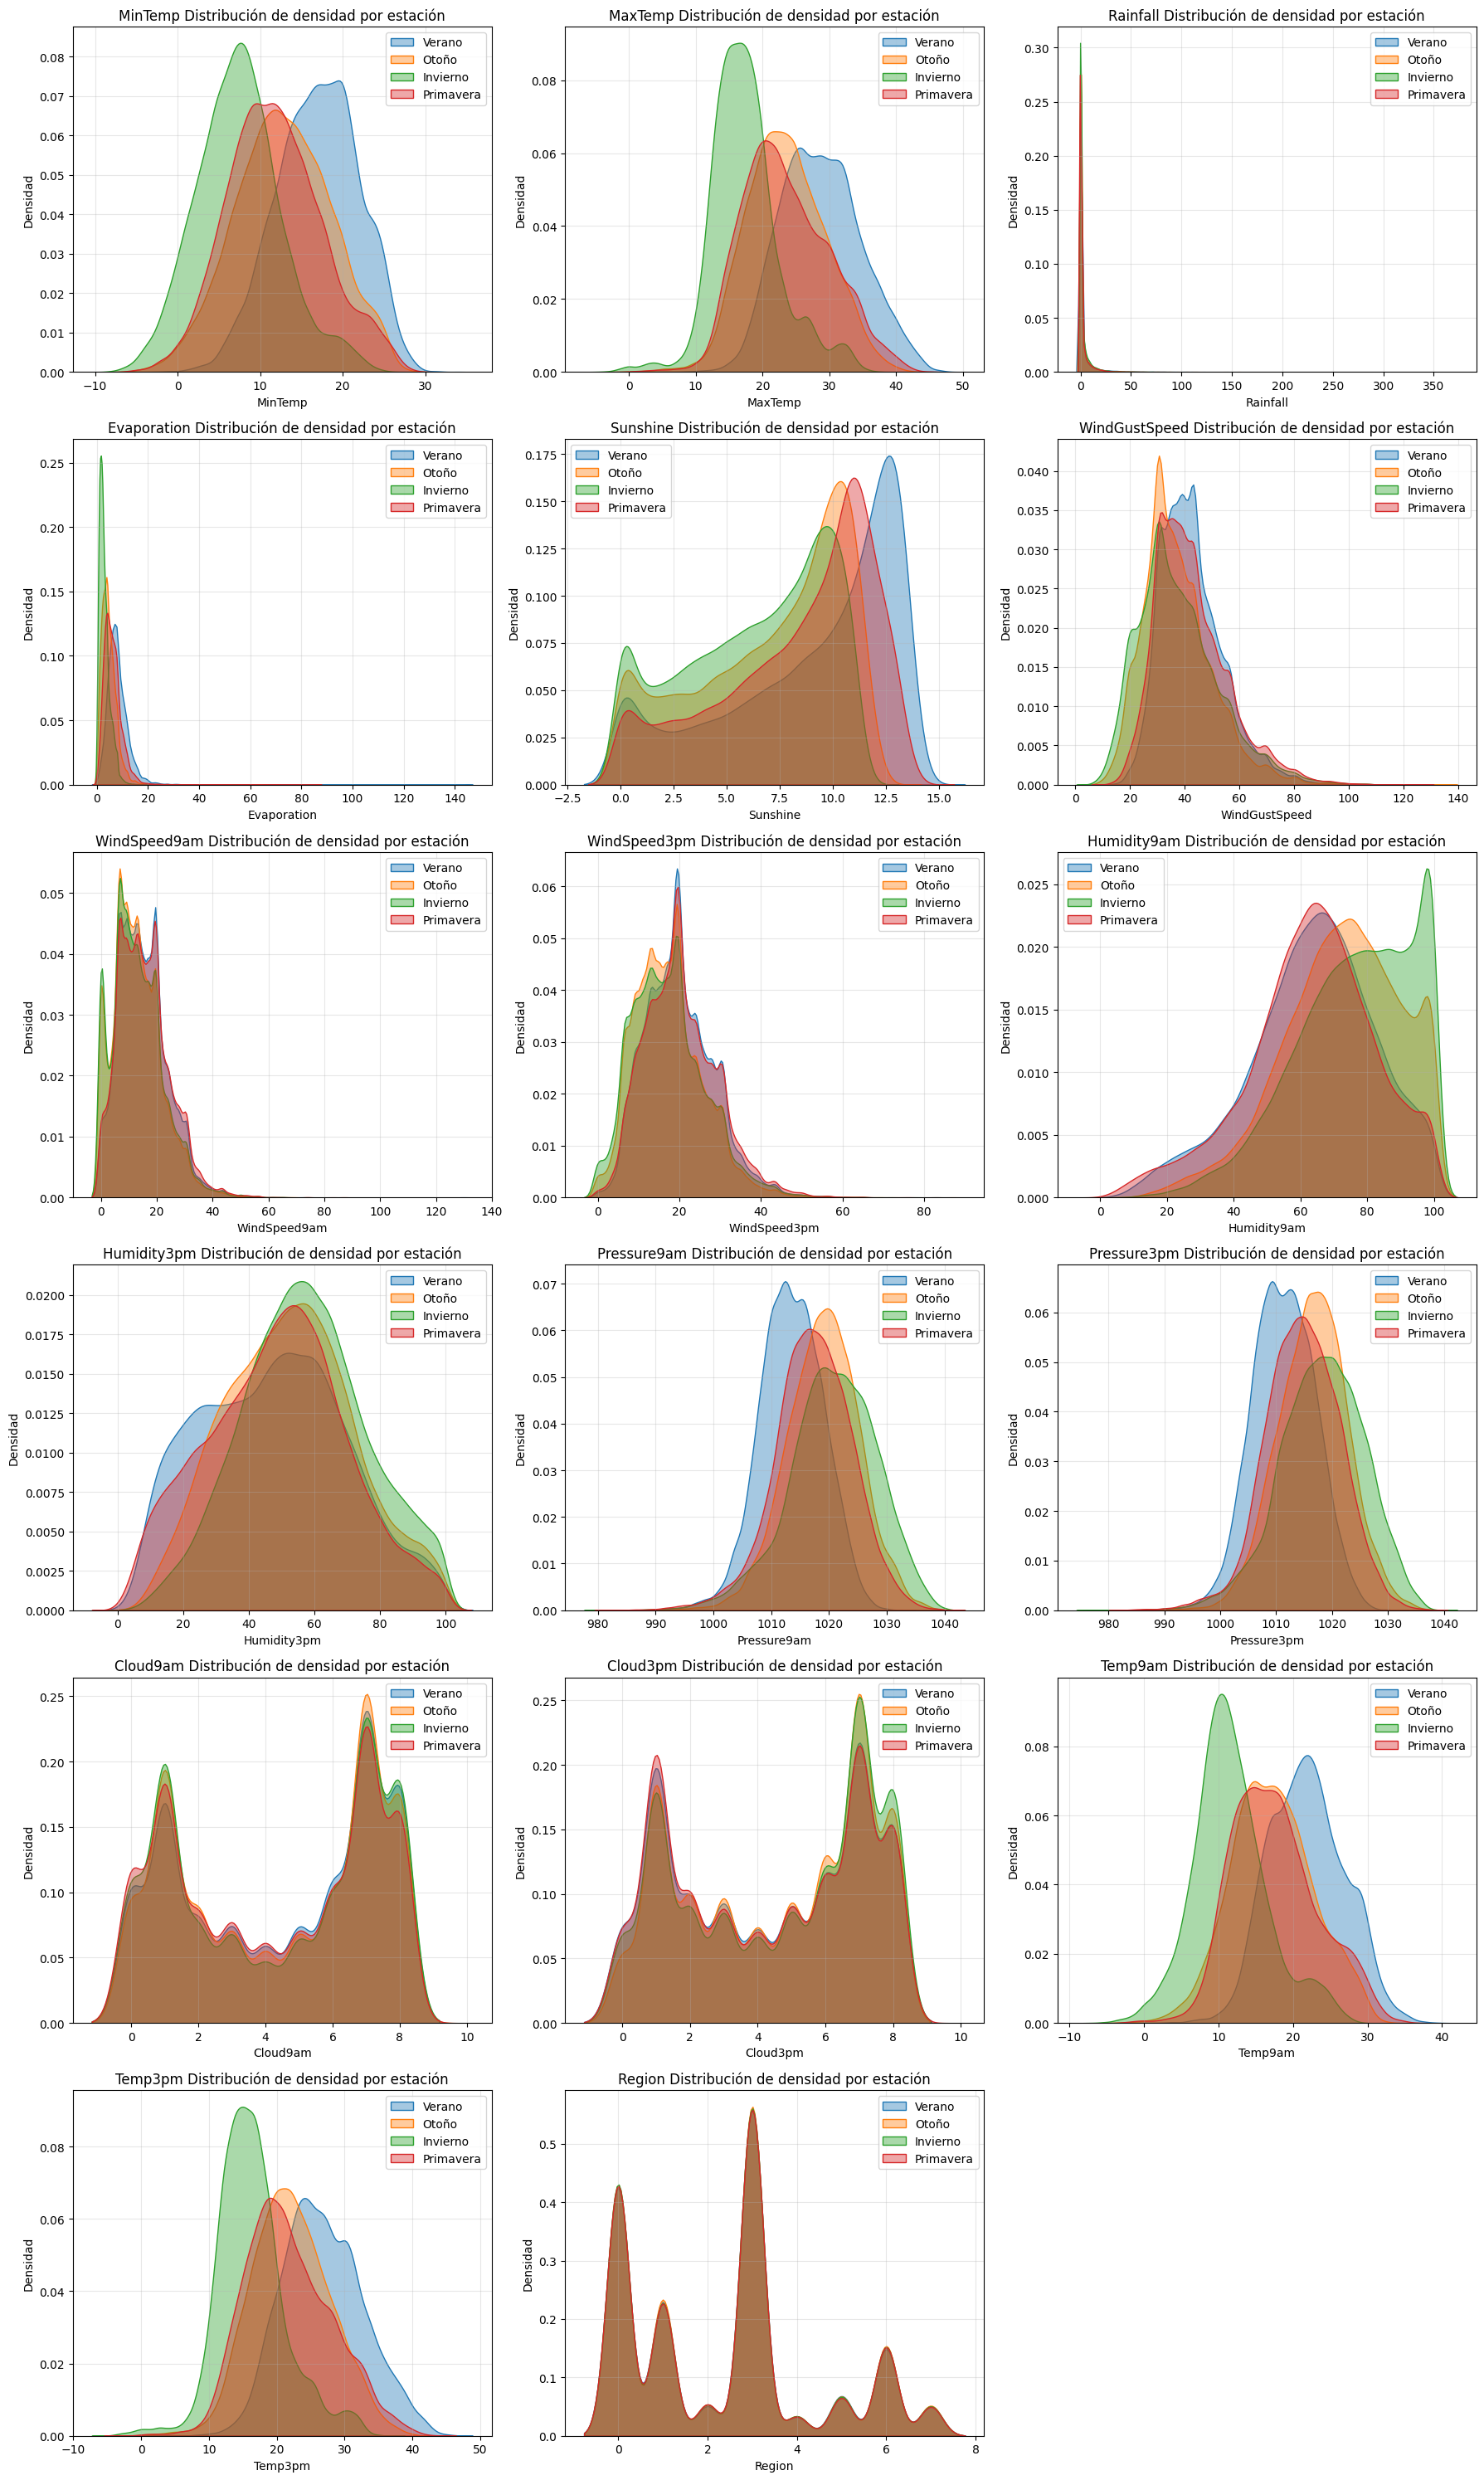

In [ ]:
# Selecciona columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Número de subplots necesarios
n_cols = len(numeric_cols)
n_rows = math.ceil(n_cols / 3)

# Subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5 * n_rows))
axes = axes.flatten()

# Distribución de densidad para cada variable numérica según estación
for i, col in enumerate(numeric_cols):
    for season in df['Season'].unique():
        data = df[df['Season'] == season][col].dropna() # Filter data by season and drop NaNs
        sns.kdeplot(data=data, ax=axes[i], label=season, fill=True, alpha=0.4)

    axes[i].set_title(f'{col} Distribución de densidad por estación')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Densidad')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Sobre las densidades se puede observar que:
- Temperatura (Temp3pm, Temp9am, MinTemp, MaxTemp): Las distribuciones están claramente separadas por estación, siendo verano la más cálida (desplazada a la derecha) e invierno la más fría (desplazada a la izquierda). Esto valida la importancia de la variable 'Season' para el modelo.

- Nubosidad (Cloud9am, Cloud3pm): La distribución es multimodal (con varios picos), especialmente notable en Cloud3pm, y muestra superposición entre las estaciones. Esto sugiere que la nubosidad es un feature complejo cuyas características no dependen únicamente de la estación.

- Lluvia (Rainfall): La distribución está sesgada a la derecha, con la gran mayoría de los valores concentrados en cero, lo cual es un indicador clave del desbalance de la variable objetivo ('RainTomorrow') y su dificultad predictiva.

- Presión (Pressure9am, Pressure3pm): Las distribuciones de presión son muy similares entre estaciones, mostrando una menor variabilidad estacional que las temperaturas, aunque la presión es ligeramente menor en verano.

## Distribucón de RainTomorrow

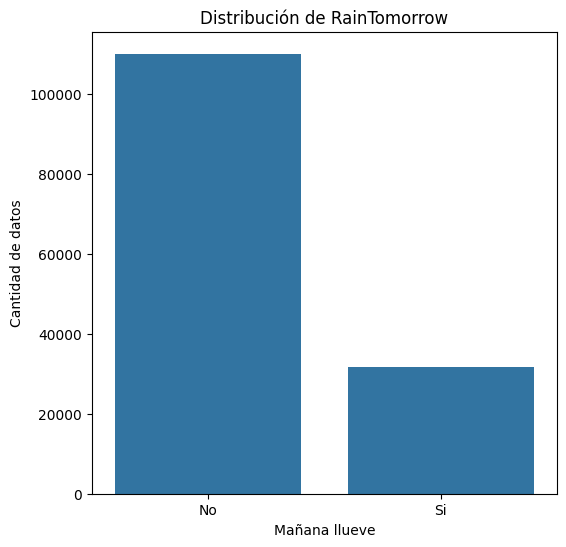

In [ ]:
plt.figure(figsize=(6, 6))
sns.countplot(x=df['RainTomorrow'].map({'No': 'No', 'Yes': 'Si'}))
plt.title('Distribución de RainTomorrow')
plt.xlabel('Mañana llueve')
plt.ylabel('Cantidad de datos')
plt.show()

Este gráfico permite ver claramente que el dataset está claramente desbalanceado y que antes de implementar una solución se deberá utilizar algún método para balancearlo.

## Boxplots según RainTomorrow

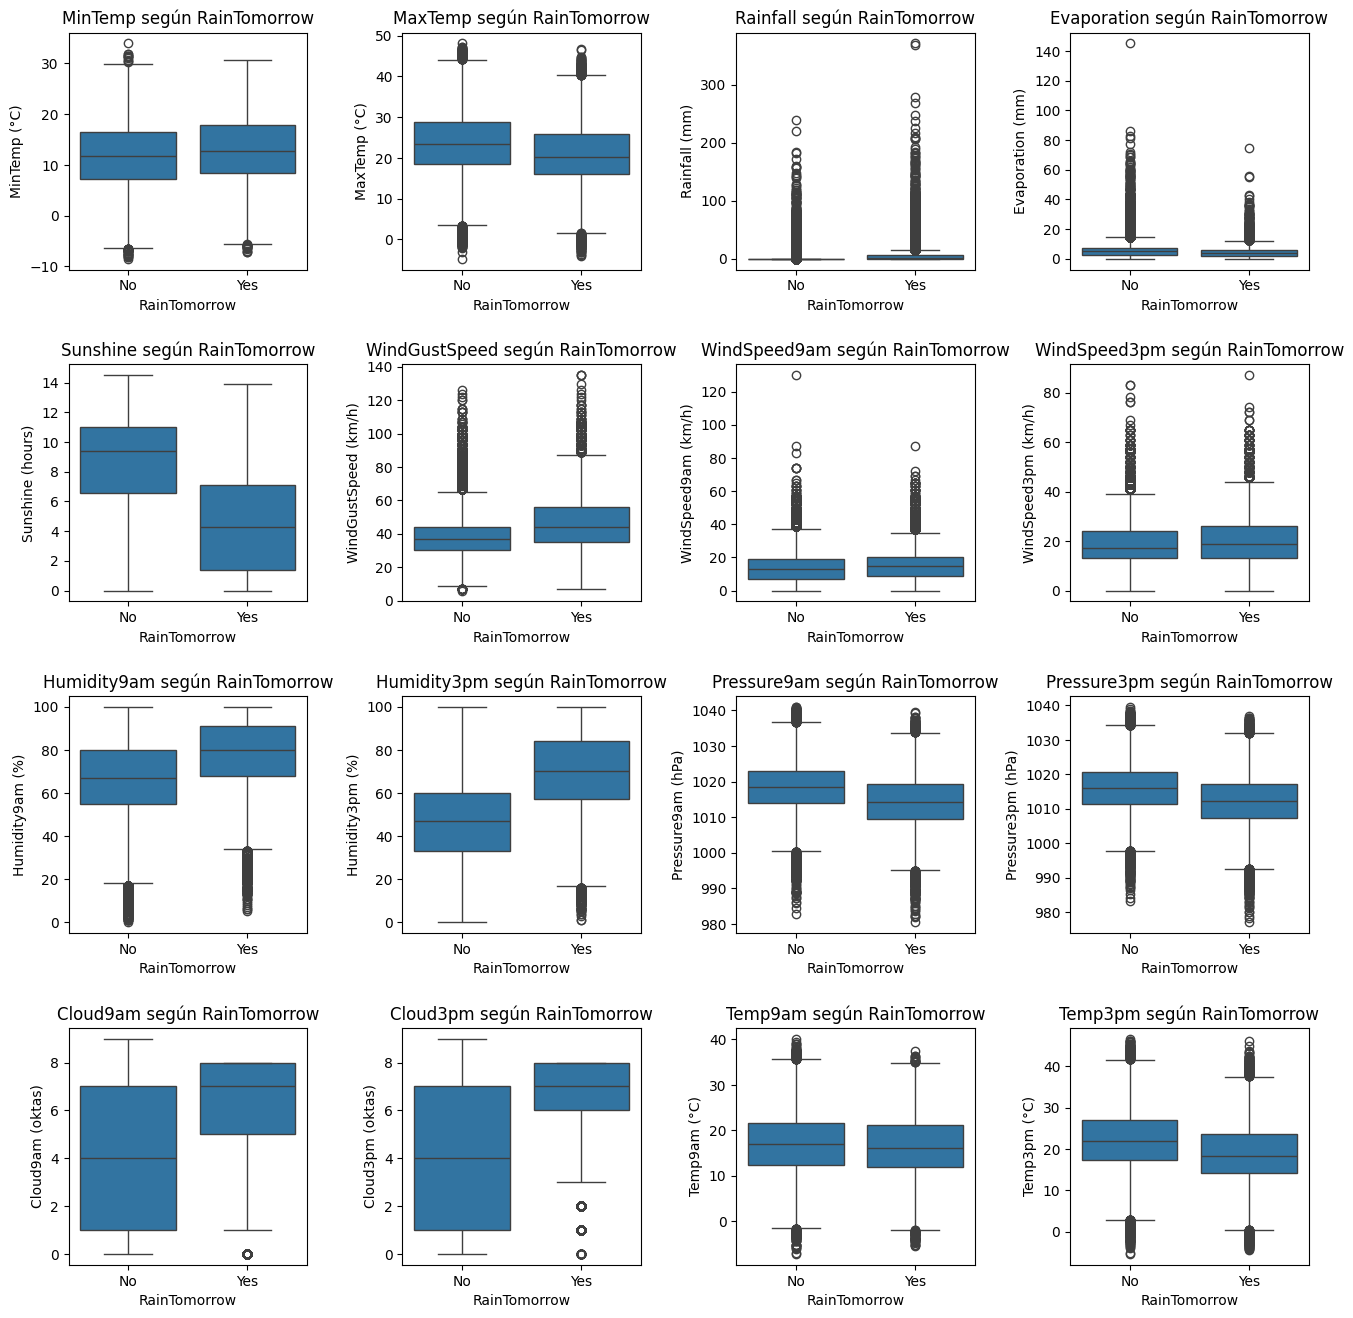

In [ ]:
df_numerico = df.select_dtypes(include=['float64', 'int64'])
num_vars = len(df_numerico.columns)

# Unidades
units = {
    'MinTemp': '°C',
    'MaxTemp': '°C',
    'Rainfall': 'mm',
    'Evaporation': 'mm',
    'Sunshine': 'hours',
    'WindGustSpeed': 'km/h',
    'WindSpeed9am': 'km/h',
    'WindSpeed3pm': 'km/h',
    'Humidity9am': '%',
    'Humidity3pm': '%',
    'Pressure9am': 'hPa',
    'Pressure3pm': 'hPa',
    'Cloud9am': 'oktas',
    'Cloud3pm': 'oktas',
    'Temp9am': '°C',
    'Temp3pm': '°C',
    'Region': ''
}


fig, axes = plt.subplots(nrows=(num_vars // 4) + (num_vars % 4 > 0), ncols=4, figsize=(16, num_vars))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, column in enumerate(df_numerico):
    row, col_idx = divmod(i, 4)
    sns.boxplot(x='RainTomorrow', data=df, y=column, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'{column} según RainTomorrow')
    axes[row, col_idx].set_xlabel('RainTomorrow')
    axes[row, col_idx].set_ylabel(f'{column} ({units.get(column, "")})')

for j in range(i + 1, axes.size):
    fig.delaxes(axes.flat[j])

plt.show()

Los gráficos de caja muestran que las variables clave para predecir la lluvia son aquellas con distribuciones visiblemente separadas entre los grupos 'No' y 'Yes'. Las features más distintivas son la Nubosidad (Cloud9am, Cloud3pm), la Humedad (Humidity9am, Humidity3pm), y las Horas de Sol (Sunshine). Por el contrario, las variables de Temperatura (MinTemp, MaxTemp, etc.) y Presión presentan distribuciones casi idénticas entre los dos grupos, indicando un bajo poder predictivo individual.

## Imputar valores faltantes

In [ ]:
def imputar_por_region_y_estacion(df_train, df_test, cols_media, cols_mediana, cols_knn):
    df_train_imputed = df_train.copy()
    df_test_imputed = df_test.copy()

    # 1. Imputar por media: calcular estadísticas del train y aplicar a ambos
    for col in cols_media:
        # Calcular la media por Region y Season del df_train
        medias = df_train_imputed.groupby(['Region', 'Season'])[col].transform('mean')
        df_train_imputed[col] = df_train_imputed[col].fillna(medias)

        # Aplicar las mismas medias al df_test
        medias_dict = df_train.groupby(['Region', 'Season'])[col].mean().to_dict()
        df_test_imputed[col] = df_test_imputed.apply(
            lambda row: medias_dict.get((row['Region'], row['Season']), row[col])
            if pd.isna(row[col]) else row[col],
            axis=1
        )

    # 2. Imputar por mediana: calcular estadísticas del train y aplicar a ambos
    for col in cols_mediana:
        # Calcular la mediana por Region y Season del df_train
        medianas = df_train_imputed.groupby(['Region', 'Season'])[col].transform('median')
        df_train_imputed[col] = df_train_imputed[col].fillna(medianas)

        # Aplicar las mismas medianas al df_test
        medianas_dict = df_train.groupby(['Region', 'Season'])[col].median().to_dict()
        df_test_imputed[col] = df_test_imputed.apply(
            lambda row: medianas_dict.get((row['Region'], row['Season']), row[col])
            if pd.isna(row[col]) else row[col],
            axis=1
        )

    # 3. Imputar por KNN: entrenar con train, transformar ambos
    for (region, season), df_region_train in df_train_imputed.groupby(['Region', 'Season']):
        # Entrenar el imputador con los datos de train
        imputador = KNNImputer(n_neighbors=5)
        imputador.fit(df_region_train[cols_knn])

        # Transformar train
        imputadas_train = imputador.transform(df_region_train[cols_knn])
        df_train_imputed.loc[df_region_train.index, cols_knn] = imputadas_train

        # Transformar test (si existen datos para esta combinación de Region y Season)
        df_region_test = df_test_imputed[
            (df_test_imputed['Region'] == region) &
            (df_test_imputed['Season'] == season)
        ]
        if len(df_region_test) > 0:
            imputadas_test = imputador.transform(df_region_test[cols_knn])
            df_test_imputed.loc[df_region_test.index, cols_knn] = imputadas_test

    return df_train_imputed, df_test_imputed

def imputar_categoricas_por_moda(df_train, df_test, cols_categoricas):
    """
    Imputa variables categóricas usando la moda por Region y Season.
    Aprende las modas del df_train y las aplica a ambos dataframes.

    Args:
        df_train: DataFrame de entrenamiento
        df_test: DataFrame de prueba
        cols_categoricas: Lista de columnas categóricas a imputar

    Returns:
        Tupla (df_train_imputed, df_test_imputed)
    """
    df_train_imputed = df_train.copy()
    df_test_imputed = df_test.copy()

    for col in cols_categoricas:
        # Calcular la moda por Region y Season del df_train
        # lambda x: x.mode()[0] if not x.mode().empty else None maneja casos sin moda
        modas_dict = df_train.groupby(['Region', 'Season'])[col].apply(
            lambda x: x.mode()[0] if not x.mode().empty else None
        ).to_dict()

        # Aplicar la moda al df_train
        df_train_imputed[col] = df_train_imputed.apply(
            lambda row: modas_dict.get((row['Region'], row['Season']), row[col])
            if pd.isna(row[col]) else row[col],
            axis=1
        )

        # Aplicar las mismas modas al df_test
        df_test_imputed[col] = df_test_imputed.apply(
            lambda row: modas_dict.get((row['Region'], row['Season']), row[col])
            if pd.isna(row[col]) else row[col],
            axis=1
        )

    return df_train_imputed, df_test_imputed

La imputación de valores faltantes se realizará con los siguientes criterior:
- Promedio ==> variables que tienen una distribución sesgada o con valores atípicos
- Media ==> distribución simétrica o normal
- KNN ==> distribuciones multimodales

In [ ]:
cols_media = ['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
cols_mediana = ['WindSpeed9am', 'WindSpeed3pm', 'WindGustSpeed']
cols_knn = ['Evaporation','Rainfall', 'Cloud9am','Cloud3pm', 'Sunshine']
cols_cat = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

## Split en train-test

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
train_df, test_df = imputar_por_region_y_estacion(train_df, test_df, cols_media, cols_mediana, cols_knn)
train_df, test_df = imputar_categoricas_por_moda(train_df, test_df, cols_cat)

In [ ]:
train_df.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
Region           0
Season           0
dtype: int64

## Codificación de variables categóricas

In [ ]:
train_df['WindGustDir'].unique()

array(['NE', 'ESE', 'SE', 'ENE', 'S', 'NNW', 'SSW', 'N', 'E', 'W', 'NW',
       'WNW', 'WSW', 'SW', 'NNE', 'SSE'], dtype=object)

Se codifican la variables 'WindGustDir', 'WindDir9am', 'WindDir3pm' de manera cíclica utilizando seno y coseno, y las variables 'Region', 'Season', 'RainToday', 'RainTomorrow' con one-hot encoding.

In [ ]:
def codificar_viento_ciclico(df_train, df_test, cols_viento):
    """
    Codifica direcciones de viento de forma cíclica usando seno y coseno.

    Args:
        df_train: DataFrame de entrenamiento
        df_test: DataFrame de prueba
        cols_viento: Lista de columnas de dirección de viento a codificar

    Returns:
        Tupla (df_train_encoded, df_test_encoded)
    """
    # Orden de las direcciones de viento (16 puntos cardinales)
    direcciones = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
                    'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']

    # Crear un mapeo de dirección a ángulo (en radianes)
    # Cada dirección está separada por 360/16 = 22.5 grados
    angulos = {direccion: (i * 2 * np.pi / 16) for i, direccion in enumerate(direcciones)}

    df_train_encoded = df_train.copy()
    df_test_encoded = df_test.copy()

    for col in cols_viento:
        # Mapear direcciones a ángulos y calcular seno y coseno
        train_angulos = df_train_encoded[col].map(angulos)
        test_angulos = df_test_encoded[col].map(angulos)

        # Crear columnas de seno y coseno
        df_train_encoded[f'{col}_sin'] = train_angulos.apply(lambda x: np.sin(x) if pd.notna(x) else np.nan)
        df_train_encoded[f'{col}_cos'] = train_angulos.apply(lambda x: np.cos(x) if pd.notna(x) else np.nan)

        df_test_encoded[f'{col}_sin'] = test_angulos.apply(lambda x: np.sin(x) if pd.notna(x) else np.nan)
        df_test_encoded[f'{col}_cos'] = test_angulos.apply(lambda x: np.cos(x) if pd.notna(x) else np.nan)

        # Eliminar la columna original
        df_train_encoded = df_train_encoded.drop(columns=[col])
        df_test_encoded = df_test_encoded.drop(columns=[col])

    return df_train_encoded, df_test_encoded


def codificar_dummies(df_train, df_test, cols_dummies):
    """
    Codifica variables categóricas usando one-hot encoding (variables dummy).

    Args:
        df_train: DataFrame de entrenamiento
        df_test: DataFrame de prueba
        cols_dummies: Lista de columnas a codificar con dummies

    Returns:
        Tupla (df_train_encoded, df_test_encoded)
    """
    # Aplicar get_dummies a train
    df_train_encoded = pd.get_dummies(df_train, columns=cols_dummies, drop_first=True)

    # Aplicar get_dummies a test
    df_test_encoded = pd.get_dummies(df_test, columns=cols_dummies, drop_first=True)

    # Asegurar que test tenga las mismas columnas que train (en el mismo orden)
    # Agregar columnas faltantes en test con valores 0
    for col in df_train_encoded.columns:
        if col not in df_test_encoded.columns:
            df_test_encoded[col] = 0

    # Reordenar las columnas de test para que coincidan con train
    df_test_encoded = df_test_encoded[df_train_encoded.columns]

    return df_train_encoded, df_test_encoded

In [ ]:
cols_viento = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
train_df, test_df = codificar_viento_ciclico(train_df, test_df, cols_viento)

cols_dummies = ['Region', 'Season', 'RainToday', 'RainTomorrow']
train_df, test_df = codificar_dummies(train_df, test_df, cols_dummies)

In [ ]:
# Todas las columnas que NO son dummies
cols_dummies = [col for col in train_df.columns if any(x in col for x in ['Region_', 'Season_', 'RainToday_'])]
# Excluir RainTomorrow_Yes del escalado (es la variable objetivo y debe mantenerse binaria)
cols_a_estandarizar = [col for col in train_df.columns
                       if col not in cols_dummies and col != 'RainTomorrow_Yes']

scaler = StandardScaler()
train_df[cols_a_estandarizar] = scaler.fit_transform(train_df[cols_a_estandarizar])
test_df[cols_a_estandarizar] = scaler.transform(test_df[cols_a_estandarizar])

In [ ]:
train_df.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'WindGustDir_sin', 'WindGustDir_cos',
       'WindDir9am_sin', 'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos',
       'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6',
       'Region_7', 'Season_Otoño', 'Season_Primavera', 'Season_Verano',
       'RainToday_Yes', 'RainTomorrow_Yes'],
      dtype='object')

## Aplicación de SMOTE-ENN para balanceo de clases

### Comparación entre SMOTE-ENN y SMOTE-Tomek

#### Diferencias esperadas entre los métodos:

**SMOTE-ENN:**
- Más agresivo en la limpieza
- Elimina más muestras (especialmente de la clase mayoritaria)
- Dataset final generalmente más pequeño
- Mejor para eliminar ruido y muestras ambiguas

**SMOTE-Tomek:**
- Más conservador
- Solo elimina pares en la frontera entre clases (Tomek Links)
- Dataset final generalmente más grande
- Mejor para mantener más información del dataset original

Tamaño entrenamiento: (113467, 33)
Tamaño prueba: (28367, 33)
Distribución en y_train:
RainTomorrow_Yes
False    0.775327
True     0.224673
Name: proportion, dtype: float64

Distribución en y_test:
RainTomorrow_Yes
False    0.778369
True     0.221631
Name: proportion, dtype: float64
Distribución ANTES de SMOTE-ENN:
Clase 0 (No llueve): 87974 (77.53%)
Clase 1 (Llueve): 25493 (22.47%)
Total: 113467

Distribución DESPUÉS de SMOTE-ENN:
Clase 0 (No llueve): 57117 (41.23%)
Clase 1 (Llueve): 81408 (58.77%)
Total: 138525


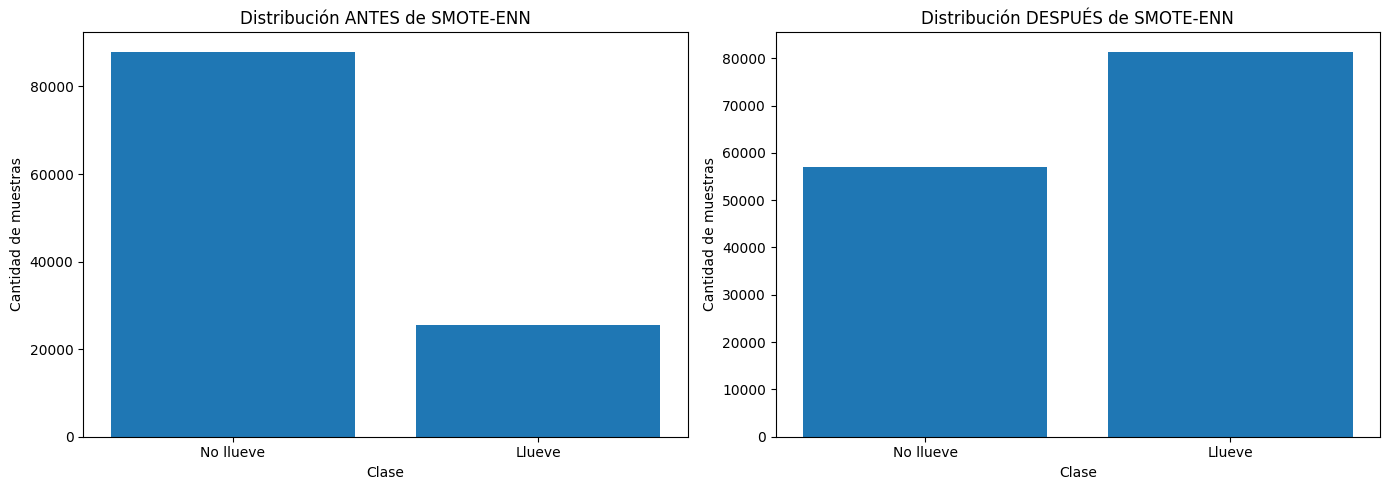

In [ ]:
# Separar las variables predictoras (X) de la variable objetivo (y)
x_train = train_df.drop(columns=['RainTomorrow_Yes'])
y_train = train_df['RainTomorrow_Yes']

x_test = test_df.drop(columns=['RainTomorrow_Yes'])
y_test = test_df['RainTomorrow_Yes']

# Reporte rápido
print("Tamaño entrenamiento:", x_train.shape)
print("Tamaño prueba:", x_test.shape)
print("Distribución en y_train:")
print(y_train.value_counts(normalize=True))
print("\nDistribución en y_test:")
print(y_test.value_counts(normalize=True))

# Verificar distribución antes de SMOTE-ENN
print("Distribución ANTES de SMOTE-ENN:")
print(f"Clase 0 (No llueve): {(y_train == 0).sum()} ({(y_train == 0).sum() / len(y_train) * 100:.2f}%)")
print(f"Clase 1 (Llueve): {(y_train == 1).sum()} ({(y_train == 1).sum() / len(y_train) * 100:.2f}%)")
print(f"Total: {len(y_train)}")

# Aplicar SMOTE-ENN solo al conjunto de entrenamiento
smote_enn = SMOTEENN(random_state=0)
x_train_resampled_enn, y_train_resampled_enn = smote_enn.fit_resample(x_train, y_train)

# Verificar distribución después de SMOTE-ENN
print("\nDistribución DESPUÉS de SMOTE-ENN:")
print(f"Clase 0 (No llueve): {(y_train_resampled_enn == 0).sum()} ({(y_train_resampled_enn == 0).sum() / len(y_train_resampled_enn) * 100:.2f}%)")
print(f"Clase 1 (Llueve): {(y_train_resampled_enn == 1).sum()} ({(y_train_resampled_enn == 1).sum() / len(y_train_resampled_enn) * 100:.2f}%)")
print(f"Total: {len(y_train_resampled_enn)}")

# Visualizar la distribución
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Antes de SMOTE-ENN
axes[0].bar(['No llueve', 'Llueve'], [((y_train == 0).sum()), ((y_train == 1).sum())])
axes[0].set_title('Distribución ANTES de SMOTE-ENN')
axes[0].set_ylabel('Cantidad de muestras')
axes[0].set_xlabel('Clase')

# Después de SMOTE-ENN
axes[1].bar(['No llueve', 'Llueve'], [((y_train_resampled_enn == 0).sum()), ((y_train_resampled_enn == 1).sum())])
axes[1].set_title('Distribución DESPUÉS de SMOTE-ENN')
axes[1].set_ylabel('Cantidad de muestras')
axes[1].set_xlabel('Clase')

plt.tight_layout()
plt.show()

Distribución DESPUÉS de SMOTE-Tomek:
Clase 0 (No llueve): 87718 (50.00%)
Clase 1 (Llueve): 87718 (50.00%)
Total: 175436


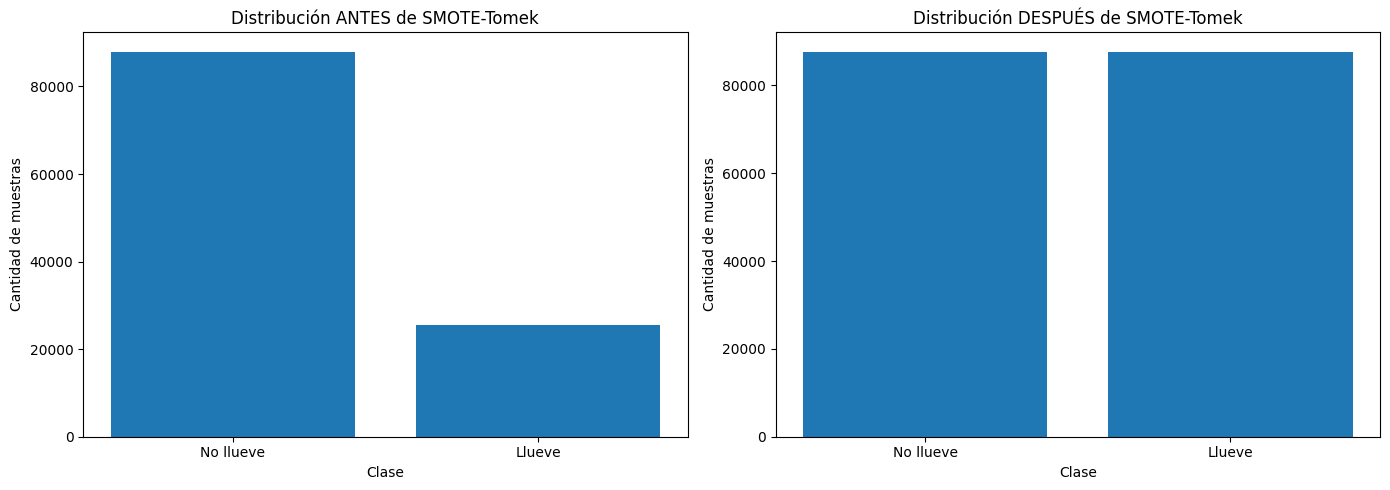

In [ ]:
# Aplicar SMOTE-Tomek solo al conjunto de entrenamiento
smote_tomek = SMOTETomek(random_state=0)
x_train_resampled_tomek, y_train_resampled_tomek = smote_tomek.fit_resample(x_train, y_train)

# Verificar distribución después de SMOTE-Tomek
print("Distribución DESPUÉS de SMOTE-Tomek:")
print(f"Clase 0 (No llueve): {(y_train_resampled_tomek == 0).sum()} ({(y_train_resampled_tomek == 0).sum() / len(y_train_resampled_tomek) * 100:.2f}%)")
print(f"Clase 1 (Llueve): {(y_train_resampled_tomek == 1).sum()} ({(y_train_resampled_tomek == 1).sum() / len(y_train_resampled_tomek) * 100:.2f}%)")
print(f"Total: {len(y_train_resampled_tomek)}")

# Visualizar la distribución
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Antes de SMOTE-Tomek
axes[0].bar(['No llueve', 'Llueve'], [((y_train == 0).sum()), ((y_train == 1).sum())])
axes[0].set_title('Distribución ANTES de SMOTE-Tomek')
axes[0].set_ylabel('Cantidad de muestras')
axes[0].set_xlabel('Clase')

# Después de SMOTE-Tomek
axes[1].bar(['No llueve', 'Llueve'], [((y_train_resampled_tomek == 0).sum()), ((y_train_resampled_tomek == 1).sum())])
axes[1].set_title('Distribución DESPUÉS de SMOTE-Tomek')
axes[1].set_ylabel('Cantidad de muestras')
axes[1].set_xlabel('Clase')

plt.tight_layout()
plt.show()

# 3. Regresión logística

In [ ]:
# x_train, y_train
# x_train_resampled_enn, y_train_resampled_enn
# x_train_resampled_tomek, y_train_resampled_tomek

model_l2 = LogisticRegression()
model_l2.fit(x_train, y_train)

y_pred_l2 = model_l2.predict(x_test)

y_pred_l2 = model_l2.predict(x_test)
y_proba_l2 = model_l2.predict_proba(x_test)[:, 1]
f1_l2 = f1_score(y_test, y_pred_l2)

print(f"F1-score (L2 default): {f1_l2:.2f}")

F1-score (L2 default): 0.58


In [ ]:
# x_train, y_train
# x_train_resampled_enn, y_train_resampled_enn
# x_train_resampled_tomek, y_train_resampled_tomek

model_l2 = LogisticRegression()
model_l2.fit(x_train, y_train)

y_pred_l2 = model_l2.predict(x_test)
f1_l2 = f1_score(y_test, y_pred_l2)

model_enn = LogisticRegression()
model_enn.fit(x_train_resampled_enn, y_train_resampled_enn)

y_pred_enn = model_enn.predict(x_test)
f1_enn = f1_score(y_test, y_pred_enn)

model_tomek = LogisticRegression()
model_tomek.fit(x_train_resampled_tomek, y_train_resampled_tomek)

y_pred_tomek = model_tomek.predict(x_test)
f1_tomek = f1_score(y_test, y_pred_tomek)

print(f"F1-score (L2 default): {f1_l2:.2f}")
print(f"F1-score (SMOTE-ENN): {f1_enn:.2f}")
print(f"F1-score (SMOTE-Tomek): {f1_tomek:.2f}")


F1-score (L2 default): 0.58
F1-score (SMOTE-ENN): 0.59
F1-score (SMOTE-Tomek): 0.62


Vemos que con un balanceo hecho a partir de SMOTE-Tomek, no sólo el valor de F1-score meejora, si no que las clases quedan cada una con $50\%$ del total de los datos. Con esto, sumado al hecho de que Tomek nos deja un dataset más grande y más fiel al original, se decidió continuar trabajando con este.

In [ ]:
y_proba = model_tomek.predict_proba(x_test)[:, 1]

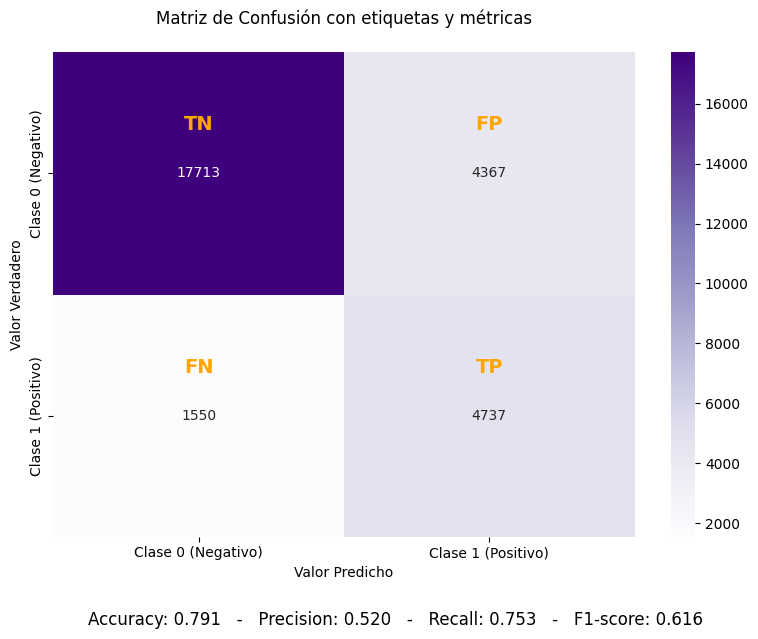

In [ ]:
# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred_tomek)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred_tomek)
precision = precision_score(y_test, y_pred_tomek)
recall = recall_score(y_test, y_pred_tomek)
f1 = f1_score(y_test, y_pred_tomek)

# Crear la figura
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Clase 0 (Negativo)', 'Clase 1 (Positivo)'],
            yticklabels=['Clase 0 (Negativo)', 'Clase 1 (Positivo)'])

plt.ylabel('Valor Verdadero')
plt.xlabel('Valor Predicho')
plt.title('Matriz de Confusión con etiquetas y métricas', pad=20)

# Anotaciones TN, FP, FN, TP (coordenadas ajustadas al centro de cada celda)
plt.text(0.5, 0.3, 'TN', ha='center', va='center', color='orange', fontsize=14, fontweight='bold')
plt.text(1.5, 0.3, 'FP', ha='center', va='center', color='orange', fontsize=14, fontweight='bold')
plt.text(0.5, 1.3, 'FN', ha='center', va='center', color='orange', fontsize=14, fontweight='bold')
plt.text(1.5, 1.3, 'TP', ha='center', va='center', color='orange', fontsize=14, fontweight='bold')

# Mostrar métricas debajo del gráfico
plt.figtext(0.5, -0.05,
            f'Accuracy: {accuracy:.3f}   -   Precision: {precision:.3f}   -   Recall: {recall:.3f}   -   F1-score: {f1:.3f}',
            wrap=True, horizontalalignment='center', fontsize=12)

plt.tight_layout()
plt.show()

- Falsos Negativos (FN = 1,550): Son los días en que el modelo predijo 'No lloverá', pero sí llovió. En el contexto de predicción de lluvia , este es el error más costoso.

- Falsos Positivos (FP = 4,367): Son los días en que el modelo predijo 'Lloverá', pero no llovió. Este error es menos costoso que el FN , pero la alta cantidad de 4,367 FPs contribuye a la baja Precision (Precision=0.520).

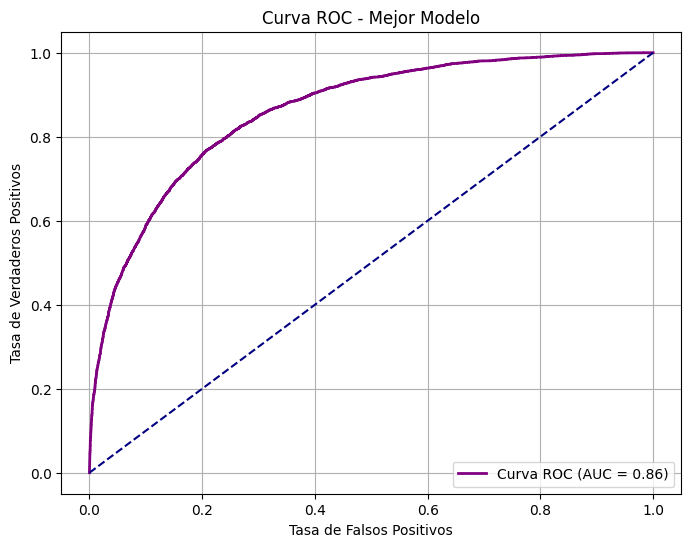


Óptimo umbral (maximizando F1-score): 0.5800
F1-score con umbral óptimo: 0.6220
F1-score con umbral 0.5: 0.6156

Métricas con umbral óptimo:
Accuracy: 0.8134
Precision: 0.5643
Recall: 0.6929
F1-score: 0.6220


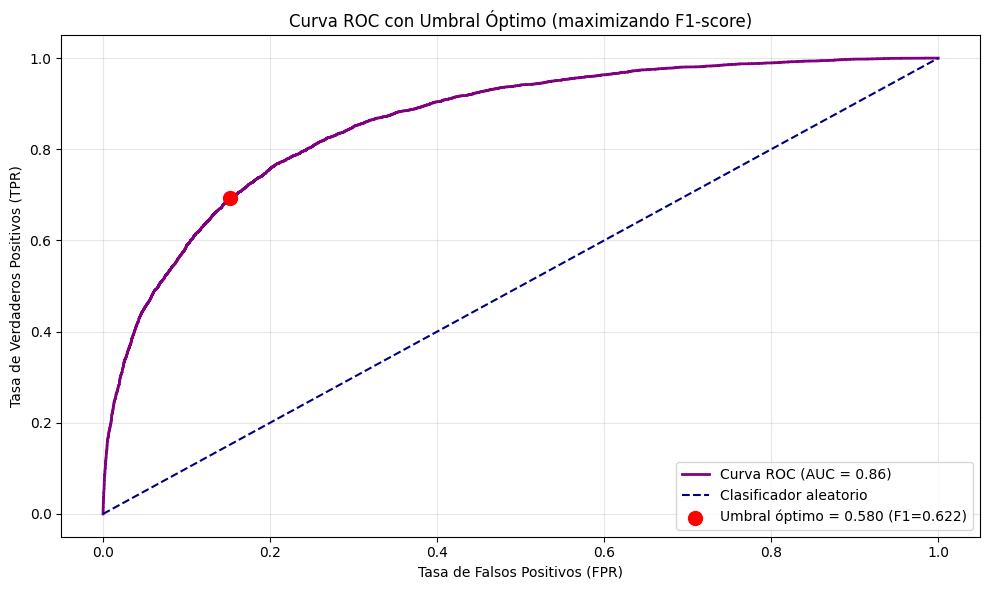

In [ ]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})', color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Mejor Modelo')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Encontrar el umbral óptimo maximizando F1-score
f1_scores = []
for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))

# Obtener el índice del mejor F1-score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
best_f1 = f1_scores[optimal_idx]

print(f"\nÓptimo umbral (maximizando F1-score): {optimal_threshold:.4f}")
print(f"F1-score con umbral óptimo: {best_f1:.4f}")
print(f"F1-score con umbral 0.5: {f1_score(y_test, y_pred_tomek):.4f}")

# Aplicar el umbral óptimo
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

# Calcular métricas con el umbral óptimo
print("\nMétricas con umbral óptimo:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimal):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimal):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_optimal):.4f}")

# Visualizar la curva ROC con el punto óptimo
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})', color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Clasificador aleatorio')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, zorder=5,
            label=f'Umbral óptimo = {optimal_threshold:.3f} (F1={best_f1:.3f})')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC con Umbral Óptimo (maximizando F1-score)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

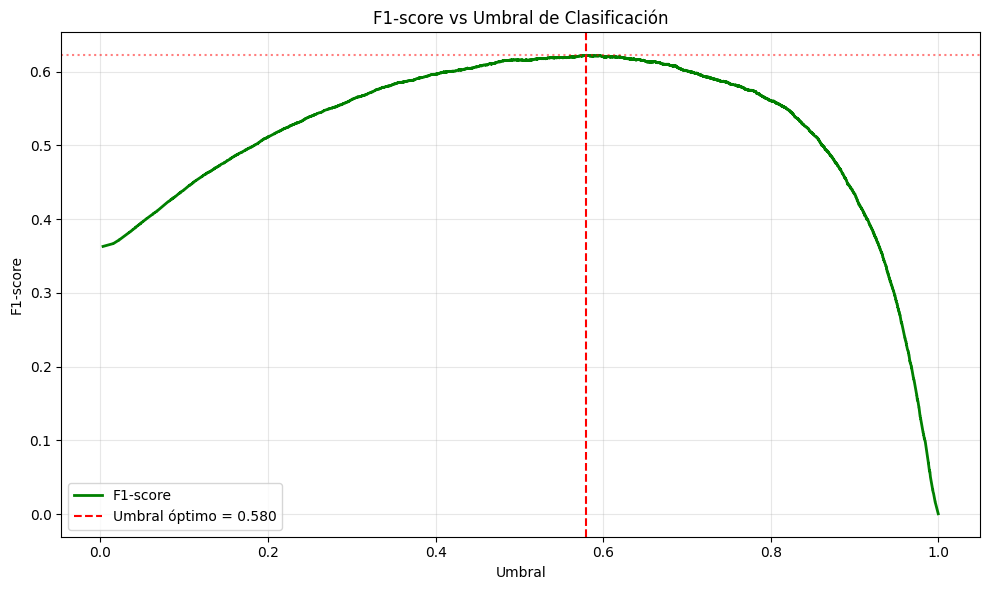


COMPARACIÓN: Umbral 0.5 vs Umbral Óptimo

Umbral = 0.5:
  Accuracy:  0.7914
  Precision: 0.5203
  Recall:    0.7535
  F1-score:  0.6156

Umbral = 0.5800 (óptimo):
  Accuracy:  0.8134
  Precision: 0.5643
  Recall:    0.6929
  F1-score:  0.6220

Mejora con umbral óptimo:
  ΔAccuracy:  +0.0220
  ΔPrecision: +0.0440
  ΔRecall:    -0.0606
  ΔF1-score:  +0.0065


In [ ]:
# Visualizar cómo varía F1-score con diferentes umbrales
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score', color='green', lw=2)
plt.axvline(optimal_threshold, color='red', linestyle='--',
            label=f'Umbral óptimo = {optimal_threshold:.3f}')
plt.axhline(best_f1, color='red', linestyle=':', alpha=0.5)
plt.xlabel('Umbral')
plt.ylabel('F1-score')
plt.title('F1-score vs Umbral de Clasificación')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Comparar métricas con umbral 0.5 vs óptimo
print("\n" + "="*60)
print("COMPARACIÓN: Umbral 0.5 vs Umbral Óptimo")
print("="*60)

# Umbral 0.5
print("\nUmbral = 0.5:")
y_pred_05 = (y_proba >= 0.5).astype(int)
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_05):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_05):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_05):.4f}")
print(f"  F1-score:  {f1_score(y_test, y_pred_05):.4f}")

# Umbral óptimo
print(f"\nUmbral = {optimal_threshold:.4f} (óptimo):")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_optimal):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_optimal):.4f}")
print(f"  F1-score:  {f1_score(y_test, y_pred_optimal):.4f}")

# Mostrar diferencias
print("\nMejora con umbral óptimo:")
print(f"  ΔAccuracy:  {accuracy_score(y_test, y_pred_optimal) - accuracy_score(y_test, y_pred_05):+.4f}")
print(f"  ΔPrecision: {precision_score(y_test, y_pred_optimal) - precision_score(y_test, y_pred_05):+.4f}")
print(f"  ΔRecall:    {recall_score(y_test, y_pred_optimal) - recall_score(y_test, y_pred_05):+.4f}")
print(f"  ΔF1-score:  {f1_score(y_test, y_pred_optimal) - f1_score(y_test, y_pred_05):+.4f}")

La Curva ROC muestra un AUC de $0.86$, lo que indica que el modelo es capaz de distinguir bien entre las clases. Observando el gráfico F1-score vs. Umbral, se determinó que el valor que maximiza el F1-score es $Umbral = 0.580$, logrando un $F1-score = 0.6220$. Al cambiar el umbral de $0.5$ a $0.580$, el F1-score mejoró en +0.0065. La mejora en F1-score se debe a un aumento de Precision (de 0.5203 a 0.5643) a expensas de una pérdida de Recall (de $0.7535$ a $0.6929$). En resumen, el umbral $0.580$ es mejor si el objetivo es maximizar el balance general.

El AUC de $0.86$ y el F1-score de $0.6220$ indican que la Regresión Logística ha conseguido un buen fitting inicial. Sin embargo, dada la alta cantidad de Falsos Positivos ($FP=4,367$) y la todavía moderada Precision ($Precision=0.5643$ con umbral óptimo), es evidente que existe margen de mejora.